In [58]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 24

@author: yaning
"""

import HH as HH
import importlib
import numpy as np
import matplotlib.pyplot as plt

importlib.reload(HH)

<module 'HH' from '/home/yaning/Documents/Spiking_NN/HH.py'>

In [59]:
# simulation environment
deltaTms = 0.05
Cm = 1
# other Vm initialisation can lead to random firing
Vm = 1.3458754117369027
# 5000 cycles and every cycle is 0.01ms
# in total 50ms
pointCount = 5000
voltages = np.empty(pointCount)
times = np.arange(pointCount) * deltaTms #record the actual time
stim = np.zeros(pointCount)
stim[1500:4000] = 20  # create a square pulse

# presynapse firing, for now has no meaning
tsp_pre = [500,2000,3500]



In [60]:
sodium_channel = HH.Voltage_Sodium(Vm)
potassium_channel = HH.Voltage_Potassium(Vm)
leaky_channel = HH.Voltage_Leak(Vm)

# because I am using factory, so the initialised values stay the same
# even the below line runs again
ampa_receptor = HH.LigandGatedChannelFactory.create_AMPA(Vm)

na_currents = []
k_currents = []
leak_currents = []
ampa_currents = []
ampa_gps = []

include_ampa = 1

for i in range(len(times)):

    sodium_channel.update_gP(deltaTms)
    potassium_channel.update_gP(deltaTms)

    if include_ampa:
        ampa_receptor.update_gP(i, deltaTms, tsp_pre)
    ampa_gps.append(ampa_receptor.gP)
    # # get the currents
    # INa = sodium_channel.current()
    # IK = potassium_channel.current()
    # Ileak = leaky_channel.current()

    # if include_ampa:
    #     Iampa = ampa_receptor.current()
    #     ampa_currents.append(Iampa)

    try:
        # get the currents
        INa = sodium_channel.current()
        IK = potassium_channel.current()
        Ileak = leaky_channel.current()

        if include_ampa:
            Iampa = ampa_receptor.current()
            ampa_currents.append(Iampa)
        else:
            Iampa = 1
        

        # check for over or underflow
        if any(current > 1e10 for current in [INa, IK, Ileak, Iampa]):
            raise OverflowError("overflowed")
        
    except OverflowError as m:
        print(f"error: {m}")
        break

    threshold = 1e-10  # Define your underflow threshold

    # Replace underflowing currents with 0
    INa = INa if abs(INa) >= threshold else 0
    IK = IK if abs(IK) >= threshold else 0
    Ileak = Ileak if abs(Ileak) >= threshold else 0
    Iampa = Iampa if abs(Iampa) >= threshold else 0


    na_currents.append(INa)
    k_currents.append(IK)
    leak_currents.append(Ileak)

    
    # print(f"time is {i}")
    print(f"INa is {INa}")
    print(f"IK is {IK}")
    print(f"Ileak is {Ileak}")
    if include_ampa:
        print(f"Iampa is {Iampa}")
    
    print("\n")

    # sum the currents
    if include_ampa:
        Isum = stim[i] - INa - IK - Ileak -Iampa
    else:
        Isum = stim[i] - INa - IK - Ileak 

    Vm += deltaTms * Isum / Cm

    voltages[i] = Vm

    # update the voltages for each channel
    sodium_channel.Vm = Vm
    potassium_channel.Vm = Vm
    leaky_channel.Vm = Vm

    if include_ampa:
        ampa_receptor.Vm = Vm

        # when post synaptic fires weight updates
        if i >= 2:
            if voltages[i-2] <= voltages[i-1] and voltages[i-1] >= voltages[i]:
                ampa_receptor.update_w(i)
                print(f"this is activated at {i}")




this line runs
this line runs
this line runs
0.2451603494963966
this line runs
this line runs
this line runs
0.2451603494963966
this line runs
this line runs
this line runs
0.2451603494963966
e is 0.9950822916666666
INa is -1.778814622592443
IK is 6.306995075638527
Ileak is -2.7762373764789285
Iampa is 3.098314238650315e-05


e is 0.9998790807237413
INa is -1.769535576320088
IK is 6.264659689748543
Ileak is -2.802516987374572
Iampa is 5.320839527660962e-05


e is 0.9999970267713374
INa is -1.7521443369566418
IK is 6.222848870870819
Ileak is -2.8279068923913093
Iampa is 6.837995228518299e-05


e is 0.9999999268926432
INa is -1.728736277368781
IK is 6.181391156913936
Ileak is -2.852549882713437
Iampa is 7.789261131389851e-05


e is 0.9999999982023967
INa is -1.7009801343189863
IK is 6.140166260592346
Ileak is -2.876552626055082
Iampa is 8.289521130221566e-05


e is 0.9999999999557996
INa is -1.6701902716198291
IK is 6.099094285702896
Ileak is -2.8999933719865263
Iampa is 8.43382048494300

In [61]:
HH.LigandGatedChannelFactory.gMax_AMPA

0.00072

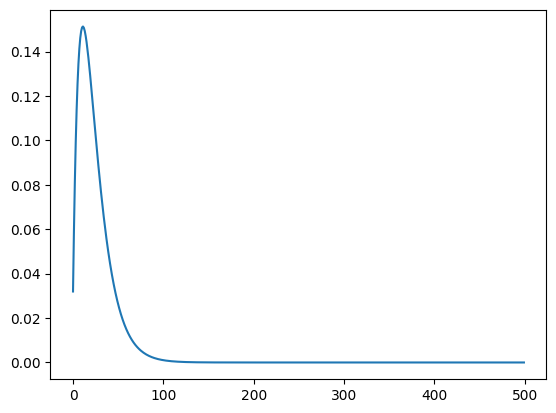

In [70]:
plt.plot(ampa_gps[:500] , label="leaky")

In [63]:
ampa_gps

[0.03197334747942382,
 0.058731556009346986,
 0.08092077399355968,
 0.09911511097649617,
 0.11382425534581464,
 0.1255003102482687,
 0.13454392651581415,
 0.14130980354637313,
 0.14611162200801664,
 0.14922646586004656,
 0.15089878544056062,
 0.15134394819536923,
 0.15075141896149064,
 0.14928760751929263,
 0.14709841734505263,
 0.1443115260891349,
 0.14103842523704044,
 0.1373762436478273,
 0.1334093771766631,
 0.12921094434837657,
 0.1248440860323007,
 0.1203631252533462,
 0.11581460164019193,
 0.11123819354076006,
 0.10666753951157304,
 0.10213096969656933,
 0.09765215653932989,
 0.09325069330858196,
 0.08894260804961246,
 0.08474081979420897,
 0.0806555431602729,
 0.07669464684149374,
 0.07286397092038721,
 0.0691676074282338,
 0.06560814811728251,
 0.062186902998855625,
 0.05890409283105563,
 0.05575901840745425,
 0.052750209199664416,
 0.049875553638666054,
 0.0471324130791167,
 0.04451772127487653,
 0.04202807100013273,
 0.039659789276589544,
 0.03740900251118608,
 0.03527169270

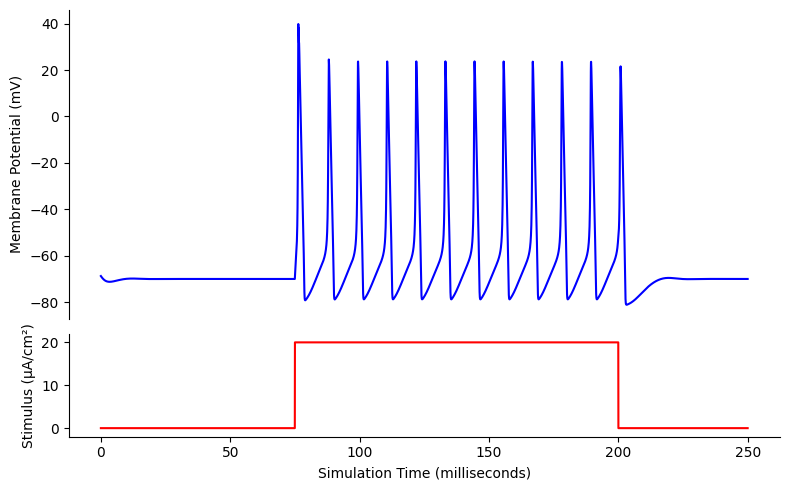

In [64]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(times, voltages - 70, 'b')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(times, stim, 'r')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
# plt.savefig("dev/concept4.png")
plt.show()

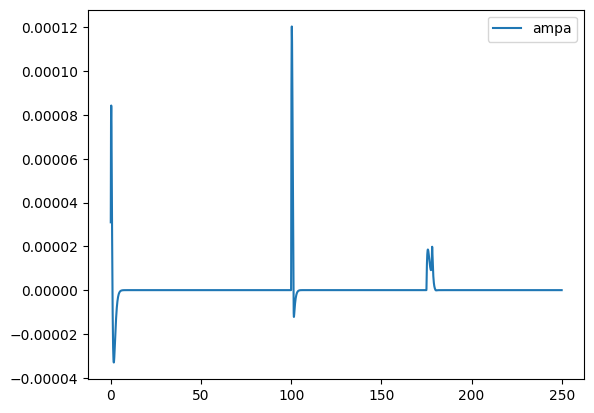

In [66]:
# plt.plot(times, leak_currents, label="leaky")
# plt.plot(times, k_currents, label="k")
# plt.plot(times, na_currents, label="na")
plt.plot(times, ampa_currents, label="ampa")
plt.legend()